In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

from src.visual_utils import plot_data_bar, plot_data_line, plot_data_line_multiple, plot_by_segment
from src.stats_utils import calculate_retention, print_basic_stats

In [2]:
files = glob.glob("data/raw/*.csv.gz")


dfs = [pd.read_csv(f, compression="gzip") for f in files]
df = pd.concat(dfs)

df["install_date"] = pd.to_datetime(df["install_date"])
df["event_date"] = pd.to_datetime(df["event_date"])

# Add a new column for later use.
df["days_after_install"] = (df["event_date"] - df["install_date"]).dt.days

In [3]:
engagement_df = df[(df["days_after_install"] == 0) & (df["total_session_duration"] > 100)]
print(len(engagement_df))

segments = ["Very Low", "Low", "Medium", "High", "Very High"]
engagement_df["segment"] = pd.qcut(
    engagement_df["total_session_duration"],
    q=len(segments),
    labels=segments
)

if "segment" not in df.columns:
    df = df.merge(
        engagement_df[["user_id", "segment"]],
        on="user_id",
        how="left"
    )

958378


C:\Users\PC\AppData\Local\Temp\ipykernel_23916\29626936.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engagement_df["segment"] = pd.qcut(


Below calculates and plots retention values for different segments.  

Parameters that can be changed for further inspection:  
- "*days_to_plot*": Content of this array is the day counts to plot the retention for.

In [ ]:
days_to_plot = [1, 3, 7]

for day_number in days_to_plot:
    plot_by_segment(
        df,
        segments,
        "segment",
        compute_series=lambda segment_df, d=day_number: calculate_retention(segment_df, day_number),
        title=f"D{day_number} retention for segments: [{", ".join(segments)}] First Day Engagements"
    )


In [ ]:
def total_session_duration_segmented(segment_df: pd.DataFrame) -> pd.Series:
    return segment_df.groupby("event_date")["total_session_duration"].sum()

In [ ]:
plot_by_segment(
    df,
    segments,
    "segment",
    compute_series=total_session_duration_segmented,
    title=f"Total session duration for segments: {', '.join(segments)} First Day Engagements"
)

In [4]:
def ending_match_percentage(segment_df: pd.DataFrame) -> pd.Series:
    match_start_count = segment_df.groupby("event_date")["match_start_count"].sum()
    match_end_count = segment_df.groupby("event_date")["match_end_count"].sum()
    return (match_end_count / match_start_count * 100)

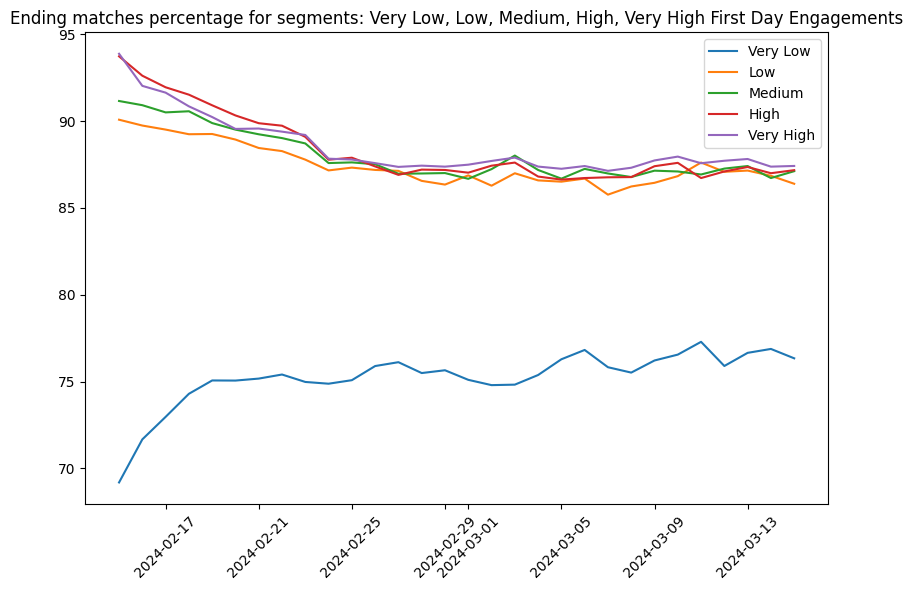

In [5]:
plot_by_segment(
    df,
    segments,
    "segment",
    compute_series=ending_match_percentage,
    title=f"Ending matches percentage for segments: {', '.join(segments)} First Day Engagements"
)

In [ ]:
def winning_match_percentage(segment_df: pd.DataFrame) -> pd.Series:
    victory = segment_df.groupby("event_date")["victory_count"].sum()
    ended = segment_df.groupby("event_date")["match_end_count"].sum()
    return (victory / ended * 100)

In [ ]:
plot_by_segment(
    df,
    segments,
    "segment",
    compute_series=winning_match_percentage,
    title=f"Winning ended matches percentage for segments: {', '.join(segments)} First Day Engagements"
)

In [ ]:
def per_session_duration(segment_df: pd.DataFrame) -> pd.Series:
    total_session_durations = segment_df.groupby("event_date")["total_session_duration"].sum()
    total_session_counts = segment_df.groupby("event_date")["total_session_count"].sum()
    return total_session_durations / total_session_counts

In [ ]:
plot_by_segment(
    df,
    segments,
    "segment",
    compute_series=per_session_duration,
    title=f"Per session duration for segments: {', '.join(segments)} First Day Engagements"
)